## **Data preprocessing and exploring**

### Access Files in Drive

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import required libraries and necessary packages

In [ ]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time


import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

### Load The data

In [ ]:
#The path of our data on drive
data_dir =  r'/content/drive/My Drive/X-Ray-Image-DataSet'
 
 
#Loading Data
data = load_files(data_dir)

In [ ]:
folders=os.listdir("/content/drive/My Drive/X-Ray-Image-DataSet")
print(folders)

['Covid-19', 'Non Covid-19']




The data set contains two folders, **Covid-19** which contains X-ray images of people  with the virus, the **Non Covid-19** which contains X-ray images of normal people


In [ ]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  /content/drive/My Drive/X-Ray-Image-DataSet/Non Covid-19/00002550_000.png
Target labels -  1
Number of training files :  625
Number of training targets :  625


### Convert images to arrays

In [ ]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 224,224 
    # Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           224*224 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        
        # update the data
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array again !
X = np.array(convert_img_to_arr(X))
 
# The Data Shape
print(X.shape) 
print('First training item : ',X[0])

(625, 224, 224, 3)
First training item :  [[[35. 35. 35.]
  [32. 32. 32.]
  [26. 26. 26.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [22. 22. 22.]]

 [[30. 30. 30.]
  [26. 26. 26.]
  [26. 26. 26.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [23. 23. 23.]]

 [[22. 22. 22.]
  [22. 22. 22.]
  [24. 24. 24.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [22. 22. 22.]]

 ...

 [[24. 24. 24.]
  [27. 27. 27.]
  [55. 55. 55.]
  ...
  [67. 67. 67.]
  [78. 78. 78.]
  [78. 78. 78.]]

 [[21. 21. 21.]
  [25. 25. 25.]
  [41. 41. 41.]
  ...
  [76. 76. 76.]
  [82. 82. 82.]
  [78. 78. 78.]]

 [[21. 21. 21.]
  [30. 30. 30.]
  [25. 25. 25.]
  ...
  [77. 77. 77.]
  [81. 81. 81.]
  [73. 73. 73.]]]


#### **Note**
#### Note that the shape of training data is **(625, 224, 224, 3)**
#####  
 
-   625 is the number of training items or files,
-   (224,224) is the target size or image size provided while loading image
-   3 refers to the depth for colored images ( RGB channels ).

### Some pictures

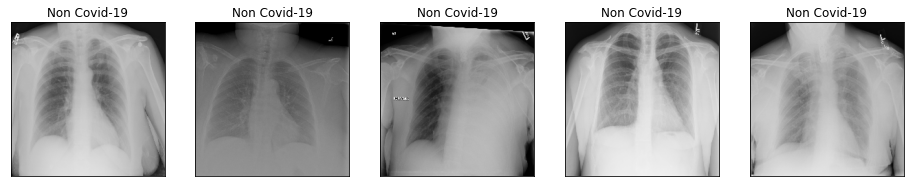

In [ ]:
# Let's look at first 5 training data. 
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [ ]:
#scaling the pixel intenties to the range[0,255]

X = X.astype('float32')/255

# Let's confirm the number of classes :) 
no_of_classes = len(np.unique(y))
no_of_classes

2

In [ ]:
y

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,

In [ ]:
# Applying one-hot encoding on the labels

y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

array([0., 1.], dtype=float32)

### Split the data into train, test and valid subsets
**80% train**, **10% validation**, and **10% test**.

In [ ]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])
 
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  500
The validation Data Shape  63
The test Data Shape  62


In [ ]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (224, 224, 3)


> **(224, 224, 3)** refers to the shape of the data (images) that will be fed into our CNN

---

### **CNN Implementation**

### Fine tuning VGG16 pre-trained model
Using Transfer Learning with advanced and popular VGG16 architecture with pre-trained weights on the popular ImageNet dataset. Then adapt it to our dataset. So, it will be our base Model

In [ ]:
# load the VGG16 model without the final layers(include_top=False)
baseModel = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])
print("Base Model loaded !")
 
"""
  Loop over all layers in the base model and freeze them so they will
  not be updated during the first training process
"""
for layer in baseModel.layers:
    layer.trainable = False
    
baseModel.summary()

58889256/58889256 [==============================] - 0s 0us/step
Base Model loaded !
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                          

### head Model
This Model we will put it later on the top of our base Model above. However, I will be using Sequential method as I am creating a sequential model. **Sequential model means that all the layers of the model will be arranged in sequence**, then i will add:
> - **AveragePooling2 layer of 4x4 pool size;**
- **Fully Connected :** 
>1. 1 x Flatten :
1. 1 x Dense of 64 units
1. 1 x Dropout  set at 50%
1. 1 x Dense of Softmax layer of 2 units
 
Few take aways :
>We are using **RELU** activation for the dense layer of 64 units so that I stop forwarding negative values through the network. I use a 2 unit dense layer in the end with softmax activation as I have 2 classes to predict from in the end which are **Covid-19** and **Non Covid-19**. The softmax layer will output the value between 0 and 1 based on the confidence of the model that which class the images belongs to.
 
>**Dropout** is a technique of regularisation which helps us to prevent **overfitting**.

In [ ]:
# In the summary above of our base model, trainable params is 0
""" Now, let's create a headModel to put on top of the base model
    (we are not freezing any layers of this model) 
"""
headModel = Sequential()
headModel.add(AveragePooling2D(pool_size=(4,4), input_shape=baseModel.output_shape[1:], name="AveragePooling2"))
headModel.add(Flatten( name ="Flatten"))
headModel.add(Dense(64, activation ="relu"))
headModel.add(Dropout(0.5, name="Dropout"))
headModel.add(Dense(no_of_classes, activation="softmax"))

headModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AveragePooling2 (AveragePoo  (None, 1, 1, 512)        0         
 ling2D)                                                         
                                                                 
 Flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 Dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 32,962
Trainable params: 32,962
Non-trainable params: 0
____________________________________________________

### Final Model
Here we are just going to put each model in its place, Yeah! We are talking about the base model (baseModel) and the head model (headModel). Therefor, we will put the first on the base and the second on the top. So, our final will look as showen below :

In [ ]:
# In the summary above of our base model, trainable params is 32, 962
""" Let's build the final model where we add the top_model on top of base_model.
    So, we will place the head Model on the top of the base Model. Therefore, this 
    'Model' will become the actual model we will train
"""
Model = Sequential()
Model.add(baseModel)
Model.add(headModel)
 
# I can check the summary of the final Model which we created by using the line of code below.
Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential (Sequential)     (None, 2)                 32962     
                                                                 
Total params: 14,747,650
Trainable params: 32,962
Non-trainable params: 14,714,688
_________________________________________________________________


### Compile the model
Using **Adam** optimiser to reach to the global minima while training our model. If I am stuck in local minima while training then the adam optimiser will help us to get out of local minima and reach global minima. We will also specify the learning rate of the optimiser, here in this case it is set at **1e-3 (0,001)**. If our training is bouncing a lot on epochs then we need to decrease the learning rate so that we can reach global minima.

In [ ]:
lr = 1e-3
epochs = 50
bs = 8
optimizer = Adam(lr = lr, decay= lr/epochs)
Model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


---

### **Modelling**

In [ ]:
# Time to train our model !
epochs = 100
 
# Initialize the training data augmentation object
train_datagen = ImageDataGenerator(
        rotation_range=15,
        fill_mode ="nearest")
 
checkpointer = ModelCheckpoint(filepath = "/content/drive/My Drive/best.h5", save_best_only = True, verbose=1)
start = time.time()
 
# let's get started !
 
history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),
                            steps_per_epoch = len(X_train)//bs,
                            validation_data = (X_valid, y_valid),
                            validation_steps = len(X_valid)//bs,
                            epochs =epochs,
                            callbacks= [checkpointer])
 
end = time.time()
duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

Epoch 1/100


<ipython-input-25-e525926cc2c0>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),


62/62 [==============================] - ETA: 0s - loss: 0.5534 - accuracy: 0.7825
Epoch 1: val_loss improved from inf to 0.47103, saving model to /content/drive/My Drive/best.h5
62/62 [==============================] - 13s 175ms/step - loss: 0.5534 - accuracy: 0.7825 - val_loss: 0.4710 - val_accuracy: 0.7937
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.4820 - accuracy: 0.7947
Epoch 2: val_loss improved from 0.47103 to 0.42317, saving model to /content/drive/My Drive/best.h5
62/62 [==============================] - 8s 130ms/step - loss: 0.4820 - accuracy: 0.7947 - val_loss: 0.4232 - val_accuracy: 0.7937
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.4280 - accuracy: 0.8008
Epoch 3: val_loss improved from 0.42317 to 0.36937, saving model to /content/drive/My Drive/best.h5
62/62 [==============================] - 7s 112ms/step - loss: 0.4280 - accuracy: 0.8008 - val_loss: 0.3694 - val_accuracy: 0.8095
Epoch 4/100
62/62 [==================

In [ ]:
(eval_loss, eval_accuracy) = Model.evaluate(  
     X_test, y_test, batch_size=bs, verbose=2)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))

8/8 - 2s - loss: 0.1355 - accuracy: 0.9677 - 2s/epoch - 219ms/step
Accuracy: 96.77%
Loss: 0.13551998138427734


### **Evaluation**

### Accuracy and Loss graphs

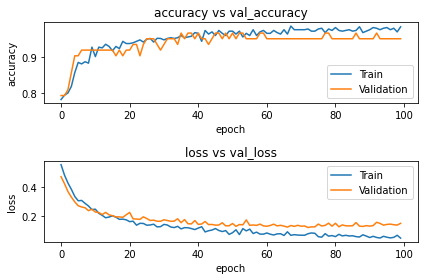

In [ ]:
# Let's visualize the train/validation loss and accuracy wrt epochs
 
import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1) 
     # Summarize history for accuracy  
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
     # Summarize history for loss  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
# Finaly, let's call the plot function with the 'result' parameter 
 
plot(history)

**Important Insights :**
- From the Training and Validation Accuracy graph above, our model does not seem to be overfitted, which is great!;
- Our Training and Validation Loss graph above also indicates a good learning rate, which is amazing !

---

### **Prediction**
Testing our model against more random samples from the test data !

2/2 [==============================] - 0s 151ms/step


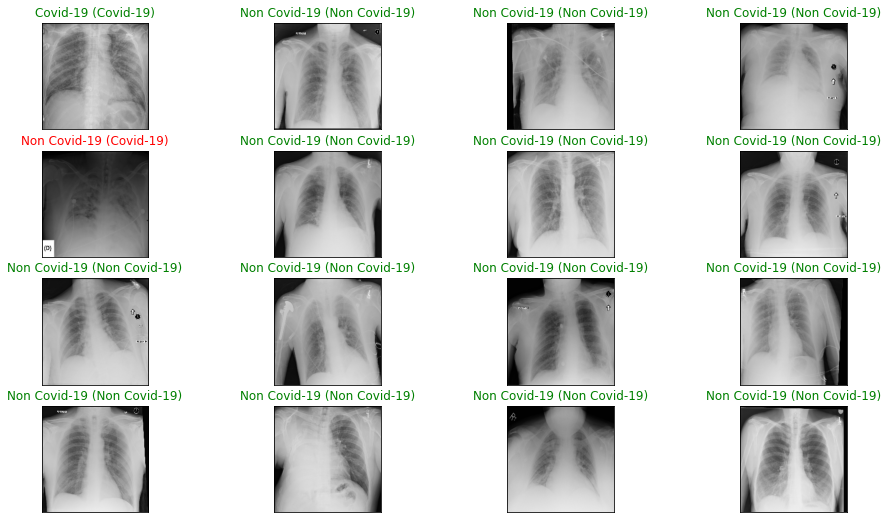

In [ ]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# Plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))
 
visualize_pred(Model.predict(X_test))

### Confusion Matrix
0 and 1 values represent Covid-19 and Non Covid-19_ respectively

2/2 [==============================] - 0s 159ms/step


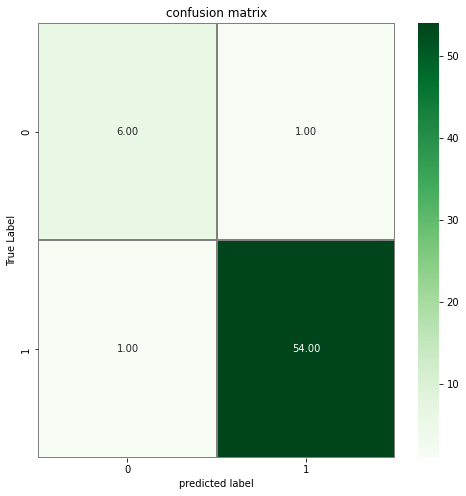

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = Model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

**Some Insights:**
- It's easier to detect is **Covid-19**, i.e. if you are infected then you are really infected
- It is clear that the model can sometimes deceive in stating that a person is not infected but it could be. Anyways, we need the expertise to explain this kind of stuff, especially when it comes to medicine. Just we must not forget that we do not have enough images for Covid-19.

- Our confusion matrix indicates that there are disturbing errors. which is Great!.

> You can check the classification report below for more information !

In [ ]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

              precision    recall  f1-score   support

    Covid-19       0.86      0.86      0.86         7
Non Covid-19       0.98      0.98      0.98        55

    accuracy                           0.97        62
   macro avg       0.92      0.92      0.92        62
weighted avg       0.97      0.97      0.97        62



### Loading the model
Loading best model trained befor, then make some predictions with it !

In [ ]:
my_model=keras.models.load_model("/content/drive/My Drive/best.h5")

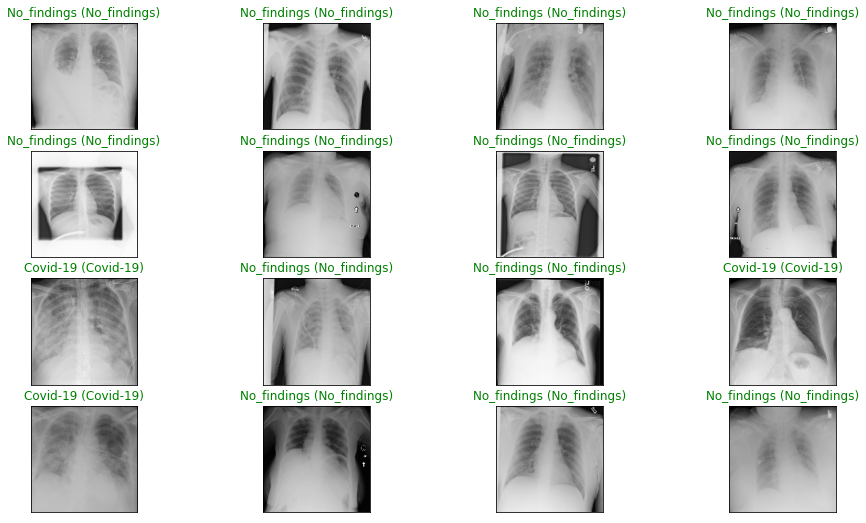

In [ ]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(my_model.predict(X_test))